In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore
from scipy.signal import spectrogram, welch

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
mouse = 25
day = 24

session_type = 'VR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230

In [3]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']

bin_size_cm = 2
positions = np.array(session['P'])
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
distance_travelled = positions+(tl*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*tl)
n_bins = int(int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)/bin_size_cm)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)
min_bound = 0

tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])

print(f'first position: {positions[0]}')
print(f'this mouse started on trial number {int(np.min(trial_numbers))}')
print(f'this mouse ended on trial number {int(np.max(trial_numbers))}')
print(f'this completed experienced {np.max(trial_numbers)-np.min(trial_numbers)+1} trials')
print(f'each trial equates to {tl} cm')
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
print(f'we will use a bin size of {bin_size_cm} cm and {n_bins} bins')
#plt.plot(distance_travelled_adjusted)
#plt.show()


first position: 122.1941375732422
this mouse started on trial number 12
this mouse ended on trial number 237
this completed experienced 226.0 trials
each trial equates to 200 cm
this mouse travelled 451.5399880409241 meters
we will use a bin size of 2 cm and 22600 bins


In [4]:
tcs = []
for index in neurons.index:
    this_neuron = neurons[neurons.index == index]
    tc = nap.compute_1d_tuning_curves(this_neuron, tmp_TSD["dt"], nb_bins=n_bins, minmax=[min_bound, max_bound])[index]
    mask = np.isnan(tc)
    tc = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=2.5)
    tcs.append(tc)

In [14]:
windowsize=4
L = tl
zmaps = tcs
min_freq, max_freq = 1 / 500, 1 / 20  # cm^-1
nperseg = windowsize * L
nperseg = 1600

Sxs, phase_grams = [], []
for mp in zmaps:
    f, t, Sxx = spectrogram(mp.ravel(), nperseg=nperseg, noverlap=1400)
    _, _, phase_gram = spectrogram(
        mp.ravel(), nperseg=nperseg, mode="angle", noverlap=1400
    )
    Sxs.append(Sxx[(min_freq < f) & (f < max_freq)])
    phase_grams.append(phase_gram[(min_freq < f) & (f < max_freq)])

Sxs = np.stack(Sxs)
Sxs = np.nan_to_num(Sxs / (np.linalg.norm(Sxs, axis=1, keepdims=True) + 1e-5))


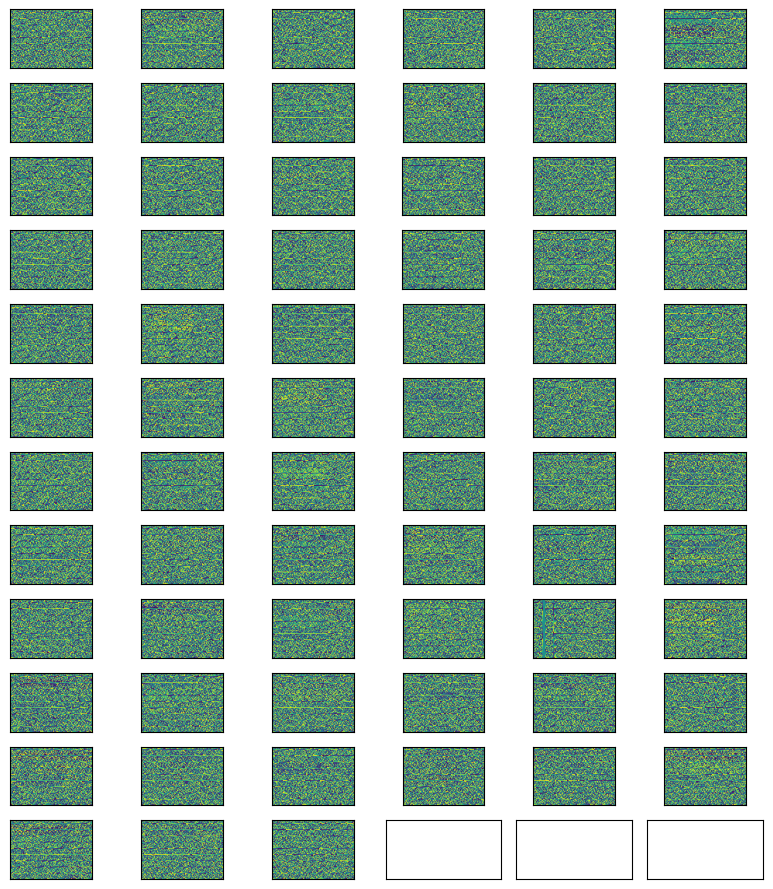

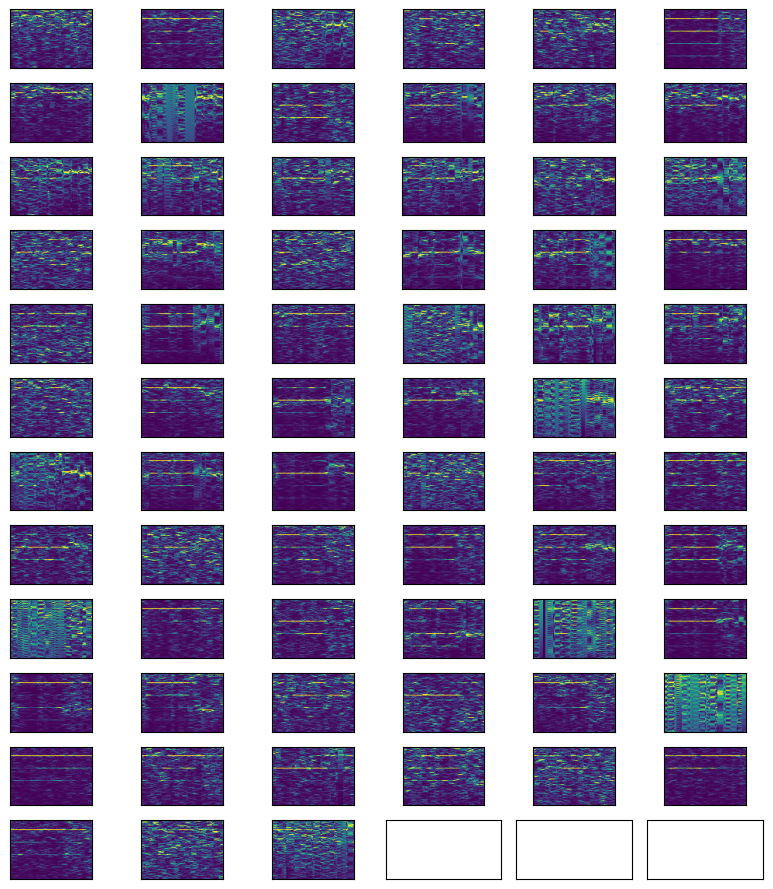

In [18]:
# Plot
ncols = 6
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
id = 0
for j in range(nrows):
    for i in range(ncols):
        if id<len(tcs):
            ax[j, i].imshow(phase_grams[id])
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        id+=1
plt.tight_layout()
plt.show()

# Plot
ncols = 6
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
id = 0
for j in range(nrows):
    for i in range(ncols):
        if id<len(tcs):
            ax[j, i].imshow(np.clip(Sxs[id], max=np.nanpercentile(Sxs[id], 99)))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        id+=1
plt.tight_layout()
plt.show()